# Análise de Correlação do Classificador e Cálculo coerência do conjunto de dados Cohebert Manual.

Realiza a análise de correlação entre as classificações realizadas e o cálculo de medida de coerência utilizando BERT no Cohebert Manual.

----------------------------

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers

**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf

**Artigo padding dinâmico:**
https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e

# 1 Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## 1.1 Tempo inicial de processamento

In [1]:
# Import das bibliotecas
import time
import datetime

#marca o tempo de início do processamento.
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [2]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [3]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [4]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [5]:
def carregar(nomeArquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nomeArquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [6]:
def carregarLista(nomeArquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nomeArquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [7]:
def salvar(nomeArquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nomeArquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [8]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempoArredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempoArredondado))    

Calcula a média de uma lista tempo string no formato hh:mm:ss.

In [9]:
# Import das bibliotecas.
from cmath import rect, phase
from math import radians, degrees
  
def mediaAngulo(deg):
    return degrees(phase(sum(rect(1, radians(d)) for d in deg)/len(deg)))
 
def mediaTempo(tempos):
    '''
    Calcula a média de uma lista de tempo string no formato hh:mm:ss
    '''
    t = (tempo.split(':') for tempo in tempos)
    # Converte para segundos
    segundos = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t)
    # Verifica se deu algum dia
    dia = 24 * 60 * 60
    # Converte para angulos
    paraAngulos = [s * 360. / dia for s in segundos]
    # Calcula a média dos angulos
    mediaComoAngulo = mediaAngulo(paraAngulos)
    media_segundos = mediaComoAngulo * dia / 360.
    if media_segundos < 0:
        media_segundos += dia
    # Recupera as horas e os minutos  
    h, m = divmod(media_segundos, 3600)
    # Recupera os minutos e os segundos
    m, s = divmod(m, 60)    
    return '{:02d}:{:02d}:{:02d}'.format(int(h), int(m), int(s))

Calcula a soma de uma lista de tempo string no formato hh:mm:ss

In [10]:
def somaTempo(tempos):
    '''
    Calcula a soma de uma lista de tempo string no formato hh:mm:ss
    '''
    t = (tempo.split(':') for tempo in tempos)
    # Converte para segundos
    segundos = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t)
    # Soma os segundos
    soma_segundos = sum([s * 1. for s in segundos])
    # Recupera as horas e os minutos   
    h, m = divmod(soma_segundos, 3600)
    # Recupera os minutos e os segundos
    m, s = divmod(m, 60)    
    return '{:02d}:{:02d}:{:02d}'.format(int(h), int(m), int(s))

Classe(ModeloArgumentosMedida) de definição dos parâmetros do modelo para medida

In [11]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )

Classe(ModeloArgumentosClassificacao) de definição dos parâmetros do modelo para classificação

In [12]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosClassificacao:
    '''
    Classe(ModeloArgumentosClassificacao) de definição dos parâmetros do modelo BERT para a classificação de coerência.
    '''
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )
    num_labels: int = field(
        default=2,
        metadata={"help": "número de rótulos a serem classificados."},
    )
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    optimizer: str = field(
        default="AdamW",
        metadata={"help": "otimizador do modelo."},
    )
    use_wandb : bool = field(
        default=True,
        metadata={"help": "habilita o uso do wandb."},
    )
    salvar_modelo_wandb : bool = field(
        default=True,
        metadata={"help": "habilita o salvamento do modelo no wandb."},
    )
    salvar_modelo : bool = field(
        default=False,
        metadata={"help": "habilita o salvamento do modelo."},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={"help": "habilita o salvamento do resultado da avaliação."},
    )     
    salvar_classificacao : bool = field(
        default=False,
        metadata={"help": "habilita o salvamento da classificação."},
    )
    usar_mcl_ajustado: bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )    
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos perturbados comparados com o seu original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de previsões de palavras recuperadas mais próximas da máscara."},
    ) 
    epoca: int = field(
        default="1",
        metadata={"help": "Época a ser avaliada."},
    )    
    fold: int = field(
        default="1",
        metadata={"help": "Fold a ser avaliado."},
    )    

Biblioteca de limpeza de tela


In [13]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [14]:
# Biblioteca de logging
import logging

# Formatando a mensagem de logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## 1.4  Identificando o ambiente Colab

In [15]:
# Se estiver executando no Google Colaboratory.
import sys

# Retorna true ou false se estiver no Google Colaboratory.
IN_COLAB = 'google.colab' in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [16]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

2022-08-05 13:48:24,552 : INFO : NumExpr defaulting to 2 threads.
2022-08-05 13:48:25,052 : INFO : Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [17]:
# Import das bibliotecas.
import torch

def getDeviceGPU():
    """
      Retorna um dispositivo de GPU se disponível ou CPU.
    
      Retorno:
        `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [18]:
# Recupera o device com GPU ou CPU
device = getDeviceGPU()

2022-08-05 13:48:27,795 : INFO : Sem GPU disponível, usando CPU.


Memória

Memória disponível no ambiente

In [19]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

2022-08-05 13:48:27,816 : INFO : Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

2022-08-05 13:48:27,819 : INFO : Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
2022-08-05 13:48:27,829 : INFO : e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [20]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")

Mounted at /content/drive


## 1.8 Instalação BERT da Hugging Face

Instala a interface pytorch para o BERT by Hugging Face. 

In [21]:
!pip install -U transformers==4.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 7.6 MB/s 
     |████████████████████████████████| 880 kB 48.7 MB/s 
     |████████████████████████████████| 3.3 MB 41.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=2f54b983a6a9a1cbab2829b05d84d8afe695f862e3c435dab6a8c44890af948a
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


### Funções Auxiliares

In [22]:
def getNomeModeloBERT(model_args):
    '''    
    Recupera uma string com uma descrição do modelo BERT para nomes de arquivos e diretórios.
    
    Parâmetros:
    `model_args` - Objeto com os argumentos do modelo.       
    
    Retorno:
    `MODELO_BERT` - Nome do modelo BERT.
    '''

    # Verifica o nome do modelo(default SEM_MODELO_BERT)
    MODELO_BERT = "SEM_MODELO_BERT"
    
    if 'neuralmind' in model_args.pretrained_model_name_or_path:
        MODELO_BERT = "_BERTimbau"
        
    else:
        if 'multilingual' in model_args.pretrained_model_name_or_path:
            MODELO_BERT = "_BERTmultilingual"
            
    return MODELO_BERT

In [23]:
def getTamanhoBERT(model_args):
    '''    
    Recupera uma string com o tamanho(dimensão) do modelo BERT para nomes de arquivos e diretórios.
    
    Parâmetros:
    `model_args` - Objeto com os argumentos do modelo.       
    
    Retorno:
    `TAMANHO_BERT` - Nome do tamanho do modelo BERT.
    '''
    
    # Verifica o tamanho do modelo(default large)
    TAMANHO_BERT = "_large"
    
    if 'base' in model_args.pretrained_model_name_or_path:
        TAMANHO_BERT = "_base"
        
    return TAMANHO_BERT  

# 2 Parametrização

## Gerais

In [24]:
# Definição dos parâmetros a serem avaliados

## Específicos

## Nome do diretório dos arquivos de dados

In [25]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHEBERT_MANUAL"

## Define o caminho para os arquivos de dados

In [26]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

# 3 Resultado do Classificador Binário usando o Método Kfold

In [27]:
# Nome base das saidas do projeto C = Cris, SB = SmartBatch, KF = KFold
NOME_BASE_SAIDA = "AjusteFinoCohebertManual_v1_C_SB_KF"

## 3.1 Carrega o resultado e parâmetros da melhor classificação

### 3.1.1 Função que encontra a melhor classificação

In [28]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosClassificacaoKFold(DIRETORIO_COHEBERT, 
                                    _DOCUMENTOS_PERTURBADOS, 
                                    _TOP_K_PREDICAO):
  
  # Numero de Folds
  KFOLDS = 10

  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = _DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = _TOP_K_PREDICAO

  # MCL a serem avaliados
  #MODELO_BERT = ['_BERTimbau','_BERTmultilingual']
  MODELO_BERT = ['_BERTimbau']

  #TAMANHO_BERT = ['_base','_large']
  TAMANHO_BERT = ['_large']
  
  # Taxa de aprendizagem do nome do arquivo
  TAXAS_DE_APRENDIZAGEM = [1, 2, 3, 4, 5]

  # Tamanho dos lotes
  TAMANHO_LOTE = [16, 32]

  # Salva resultados intermediários
  EPOCA = [2, 3, 4]

  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_classificacao_palavra/kfold/Avaliacao/"  

  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_TAXAS_DE_APRENDIZAGEM = 0
  MELHOR_TAMANHO_LOTE = 0
  MELHOR_EPOCA_EXECUCA = 0
  MELHOR_ACURACIA = 0
  MELHOR_TEMPO = 0

  lista_resultados = []

  lista_tempo_total = []  
  
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    for modelo in MODELO_BERT:    
      for tamanho in TAMANHO_BERT:
        if modelo != '_BERTmultilingual' or tamanho != '_large':                  
          for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
            for top_k_predicao in TOP_K_PREDICAO:              
              DIRETORIO_AVALIACAO_PK = DIRETORIO_AVALIACAO + "P_" + str(documentos_perturbados) + "_K_" + str(top_k_predicao) + "/"              
              # Verifica se o diretório dos resultados existe.
              if os.path.exists(DIRETORIO_AVALIACAO_PK):
                arquivos = os.listdir(DIRETORIO_AVALIACAO_PK)                 
                for lote in TAMANHO_LOTE:
                  for taxaaprendizagem in TAXAS_DE_APRENDIZAGEM:                      
                    for epoca in EPOCA:  
                        # Acumuladores.
                        soma_acuracia = 0
                        lista_tempo = []
                        conta_folds = 0 
                        conta_reg = 0
                        
                        for i in range(len(arquivos)):
                          for fold in range(1,11):
                            # Filtra o nome do arquivo a ser avaliado                                                     
                            if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                                  and (("_K_" + str(top_k_predicao)+"_") in arquivos[i]) 
                                  and (("_b_" + str(lote)) in arquivos[i]) 
                                  and (modelo in arquivos[i]) 
                                  and (tamanho in arquivos[i]) 
                                  and (('_f' + str(fold) + '_') in arquivos[i]) 
                                  and (("e_" + str(epoca)) in arquivos[i]) 
                                  and (("lr_" + str(taxaaprendizagem)) in arquivos[i])):                           

                                NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO_PK + arquivos[i]                              
                                # Verifica se o arquivo existe.
                                if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                                  # Carrega os dados do arquivo  
                                  dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                      
                                  # Conta o número de folds.
                                  conta_folds = conta_folds + 1
                                  
                                  # Mostra os dados do teste do fold.
                                  for index, linha in dados.iterrows():        
                                    # Cálculo das estatísticas
                                    acc = (linha['vp']+linha['vn'])/(linha['vp']+linha['vn']+linha['fp']+linha['fn'])                         
                                    #print('{};{};{};{:.8f};{}'.format(fold, index, arquivos[i],acc,linha['tempo']))
                                    # Guarda o tempo.
                                    lista_tempo.append(str(linha['tempo']))
                                    # Conta o número de registros.
                                    conta_reg = conta_reg + 1
                                    
                                  # Realiza a soma da acurácia do arquivo.
                                  soma_acuracia = soma_acuracia + dados['acuracia'].sum()
                                        
                        if conta_folds != 0:
                          # Calcula a média.                          
                          media_acuracia = soma_acuracia/conta_reg

                          # Guarda os resultados de todos os folds  
                          lista_resultados.append([documentos_perturbados,top_k_predicao,taxaaprendizagem,lote,epoca, media_acuracia, somaTempo(lista_tempo)])
                          
                          if media_acuracia > MELHOR_ACURACIA:
                              MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                              MELHOR_TOP_K_PREDICAO = top_k_predicao
                              MELHOR_TAXAS_DE_APRENDIZAGEM = taxaaprendizagem
                              MELHOR_TAMANHO_LOTE = lote
                              MELHOR_EPOCA_EXECUCAO = epoca
                              MELHOR_ACURACIA = media_acuracia
                              MELHOR_TEMPO = somaTempo(lista_tempo)
                       
                        else:                          
                            print('Nenhum arquivo de avaliação encontrado')
                
              else:
                print('Diretório ' + 'P_' + str(documentos_perturbados) + '_K_' + str(top_k_predicao) + ' não encontrado')                        
    
    # Retorno do melhor valor
    lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[5], reverse=True)
    return MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAXAS_DE_APRENDIZAGEM, MELHOR_TAMANHO_LOTE, MELHOR_EPOCA_EXECUCAO, MELHOR_ACURACIA, MELHOR_TEMPO, lista_resultado_ordenado
  else:
    print('Diretório com os resultados não encontrado')

Recupera os melhores resultados

In [29]:
# Parametros para o Cohebert Manual
DOCUMENTOS_PERTURBADOS = [1]
TOP_K_PREDICAO = [1]

# Recupera os melhores parâmetros
MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAXAS_DE_APRENDIZAGEM, MELHOR_TAMANHO_LOTE, MELHOR_EPOCA_EXECUCAO, MELHOR_ACURACIA, MELHOR_TEMPO, lista_resultados = getResultadosClassificacaoKFold(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO)

In [30]:
print("Parâmetros da melhor acurácia do classificador")
print("\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO, 
      "\n  Taxa de aprendizagem  :", MELHOR_TAXAS_DE_APRENDIZAGEM, 
      "\n  Lote                  :", MELHOR_TAMANHO_LOTE, 
      "\n  Epoca execução        :", MELHOR_EPOCA_EXECUCAO, 
      "\n  Acurácia              :", MELHOR_ACURACIA, 
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista das acurácias ranqueadas")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros da melhor acurácia do classificador

  Documentos Perturbados: 1 
  Top k predição        : 1 
  Taxa de aprendizagem  : 5 
  Lote                  : 16 
  Epoca execução        : 4 
  Acurácia              : 0.825 
  Tempo execução        : 00:08:17

Lista das acurácias ranqueadas
1 = [1, 1, 5, 16, 4, 0.825, '00:08:17']
2 = [1, 1, 4, 16, 4, 0.75, '00:08:14']
3 = [1, 1, 5, 32, 4, 0.75, '00:09:38']
4 = [1, 1, 3, 16, 4, 0.7, '00:08:11']
5 = [1, 1, 2, 16, 4, 0.65, '00:08:13']
6 = [1, 1, 4, 16, 3, 0.65, '00:06:00']
7 = [1, 1, 2, 32, 4, 0.65, '00:09:19']
8 = [1, 1, 5, 32, 3, 0.65, '00:07:07']
9 = [1, 1, 5, 16, 3, 0.625, '00:06:05']
10 = [1, 1, 2, 16, 3, 0.6, '00:05:59']
11 = [1, 1, 5, 16, 2, 0.6, '00:03:51']
12 = [1, 1, 3, 32, 4, 0.6, '00:09:31']
13 = [1, 1, 4, 32, 3, 0.575, '00:07:03']
14 = [1, 1, 4, 32, 4, 0.575, '00:09:38']
15 = [1, 1, 5, 32, 2, 0.575, '00:04:32']
16 = [1, 1, 1, 16, 4, 0.525, '00:07:49']
17 = [1, 1, 3, 16, 2, 0.525, '00:03:52']
18 = [1, 1, 3, 16, 3, 0.525, '00

### Escolhendo um resultado diferente do melhor

In [31]:
#MELHOR_DOCUMENTOS_PERTURBADOS = 20
#MELHOR_TOP_K_PREDICAO = 100
#MELHOR_TAXAS_DE_APRENDIZAGEM = 1
#MELHOR_TAMANHO_LOTE = 16
#MELHOR_EPOCA_EXECUCAO = 4
#MELHOR_ACURACIA = 0.9825555555555556
#MELHOR_TEMPO = '05:09:49'
#lista_resultados= []

### 3.1.2 Função que carrega e calcula a acurácia média dos folds da melhor classificação


In [32]:
# Import das bibliotecas.
import os
import pandas as pd

def relatorioResultados(DIRETORIO_COHEBERT, 
                        TEXTO_PURO, 
                        _DOCUMENTOS_PERTURBADOS, 
                        _TOP_K_PREDICAO,
                        _TAXAS_DE_APRENDIZAGEM,
                        _TAMANHO_LOTE,
                        _EPOCA_EXECUCAO
                        ):
  
  # Numero de Folds
  KFOLDS = 10

  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = _DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = _TOP_K_PREDICAO

  # MCL a serem avaliados
  #MODELO_BERT = ['_BERTimbau','_BERTmultilingual']
  MODELO_BERT = ['_BERTimbau']

  #TAMANHO_BERT = ['_base','_large']
  TAMANHO_BERT = ['_large']

  # Taxa de aprendizagem do nome do arquivo
  TAXAS_DE_APRENDIZAGEM = _TAXAS_DE_APRENDIZAGEM

  # Tamanho dos lotes
  TAMANHO_LOTE = _TAMANHO_LOTE

  # Salva resultados intermediários
  EPOCA = _EPOCA_EXECUCAO
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_classificacao_palavra/kfold/Avaliacao/"  

  lista_tempo_total = []  
  total_geral_folds = 0
  total_geral_registros = 0
  total_arquivos = (len(MODELO_BERT) * len(TAMANHO_BERT) *
                   len(DOCUMENTOS_PERTURBADOS) *  len(TOP_K_PREDICAO) * 
                   len(TAMANHO_LOTE) * len(EPOCA) * len(TAXAS_DE_APRENDIZAGEM) * KFOLDS)
  #total_arquivos = 400  
  if TEXTO_PURO == False:
    print("total_arquivos =", total_arquivos) 

  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    for modelo in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo != '_BERTmultilingual' or tamanho != '_large':  
          for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
            for top_k_predicao in TOP_K_PREDICAO:        
              DIRETORIO_AVALIACAO_PK = DIRETORIO_AVALIACAO + "P_" + str(documentos_perturbados) + "_K_" + str(top_k_predicao) + "/"
        
              # Verifica se o diretório dos resultados existe.
              if os.path.exists(DIRETORIO_AVALIACAO_PK):
                arquivos = os.listdir(DIRETORIO_AVALIACAO_PK) 
                for lote in TAMANHO_LOTE:
                  for taxaaprendizagem in TAXAS_DE_APRENDIZAGEM:
                    for epoca in EPOCA:                    
                        # Acumuladores.
                        soma_acuracia = 0
                        lista_tempo = []
                        conta_folds = 0 
                        conta_reg = 0
                        if TEXTO_PURO == False:
                           print("\nModelo:", modelo, " Tamanho:", tamanho, " N Doc:",documentos_perturbados,
                                 " Top k:", top_k_predicao, " Lote:", lote, " Taxa Apred.:", taxaaprendizagem, " Época:", epoca)
       
                        for i in range(len(arquivos)):                                    
                          for fold in range(1,11):                                                         
                            if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                                and (("_K_" + str(top_k_predicao)+"_") in arquivos[i]) 
                                and (("_b_" + str(lote)) in arquivos[i]) 
                                and (modelo in arquivos[i]) 
                                and (tamanho in arquivos[i]) 
                                and (("_b_" + str(lote)) in arquivos[i]) 
                                and (('_f' + str(fold) + '_') in arquivos[i]) 
                                and (("e_" + str(epoca)) in arquivos[i]) 
                                and (("lr_" + str(taxaaprendizagem)) in arquivos[i])):
                             
                                NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO_PK + arquivos[i]                              
                                # Verifica se o arquivo existe.
                                if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                                  # Carrega os dados do arquivo  
                                  dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                      
                                  # Conta o número de folds.
                                  conta_folds = conta_folds + 1
                                  # Conta o número geral de folds
                                  total_geral_folds = total_geral_folds + 1

                                  # Mostra os dados do teste do fold.
                                  for index, linha in dados.iterrows():        
                                    # Cálculo das estatísticas
                                    acc = (linha['vp']+linha['vn'])/(linha['vp']+linha['vn']+linha['fp']+linha['fn'])                         
                                    print('{};{};{};{};{}'.format(fold, index, arquivos[i],str(acc).replace(".", ","),linha['tempo']))
                                    #print('{};{};{};{:.8f};{}'.format(fold, index, arquivos[i],acc,linha['tempo']))
                                    # Guarda o tempo.
                                    lista_tempo.append(str(linha['tempo']))

                                    # Conta o número de registros.
                                    conta_reg = conta_reg + 1
                                    # Conta o número geral de registros.
                                    total_geral_registros = total_geral_registros + 1

                                  # Realiza a soma da acurácia do arquivo.
                                  soma_acuracia = soma_acuracia + dados['acuracia'].sum()

                        
                        if conta_folds != 0:
                            # Mostra a soma da acurácia . 
                            if TEXTO_PURO == False:
                              print('Total acurácia                                           : {:.8f}'.format(soma_acuracia))
                            # Mostra a quantidade de folds.
                            if TEXTO_PURO == False:
                              print('Quantidade de folds                                      : {}'.format(conta_folds))  
                            # Mostra a quantidade de registros.
                            if TEXTO_PURO == False:
                              print('Quantidade de registros                                  : {}'.format(conta_reg))  
                            # Calcula a média.
                            if TEXTO_PURO == False:
                              media_acuracia = soma_acuracia/conta_reg
                              print('A média da acurácia de {:2d} registros é                    : {:.8f}'.format(conta_reg, media_acuracia))
                              print('O tempo gasto na execução do treinamento {:2d} registros é  : {}'.format(conta_reg, somaTempo(lista_tempo)))
                              print('A média de tempo de execução de {:2d} registros é           : {}\n'.format(conta_reg, mediaTempo(lista_tempo)))
                            
                            if epoca == 4:
                              # Guarda o tempo total
                              lista_tempo_total.append(somaTempo(lista_tempo))
                        else:
                            if TEXTO_PURO == False:
                              print('Nenhum arquivo de avaliação encontrado')
                                    
              else:
                print('Diretório ' + 'P_' + str(documentos_perturbados) + '_K_' + str(top_k_predicao) + ' não encontrado')                        
    
  else:
      print('Diretório com os resultados não encontrado')        

Recupera os dados dos melhores resultados

In [33]:
# Diretório do cohebert
DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
TAXAS_DE_APRENDIZAGEM = [MELHOR_TAXAS_DE_APRENDIZAGEM]
TAMANHO_LOTE = [MELHOR_TAMANHO_LOTE]
EPOCA_EXECUCAO = [MELHOR_EPOCA_EXECUCAO]
TEXTO_PURO = False

relatorioResultados(DIRETORIO_COHEBERT, 
                    TEXTO_PURO, 
                    DOCUMENTOS_PERTURBADOS, 
                    TOP_K_PREDICAO, 
                    TAXAS_DE_APRENDIZAGEM, 
                    TAMANHO_LOTE, 
                    EPOCA_EXECUCAO)

total_arquivos = 10

Modelo: _BERTimbau  Tamanho: _large  N Doc: 1  Top k: 1  Lote: 16  Taxa Apred.: 5  Época: 4
1;0;AjusteFinoCohebertManual_v1_C_SB_KF_P_1_K_1_E_4_e_4_lr_5_b_16_16_f1_BERTimbau_large.csv;0,75;0:00:50
2;0;AjusteFinoCohebertManual_v1_C_SB_KF_P_1_K_1_E_4_e_4_lr_5_b_16_16_f2_BERTimbau_large.csv;0,5;0:00:51
3;0;AjusteFinoCohebertManual_v1_C_SB_KF_P_1_K_1_E_4_e_4_lr_5_b_16_16_f3_BERTimbau_large.csv;1,0;0:00:49
4;0;AjusteFinoCohebertManual_v1_C_SB_KF_P_1_K_1_E_4_e_4_lr_5_b_16_16_f4_BERTimbau_large.csv;1,0;0:00:50
5;0;AjusteFinoCohebertManual_v1_C_SB_KF_P_1_K_1_E_4_e_4_lr_5_b_16_16_f5_BERTimbau_large.csv;0,75;0:00:49
6;0;AjusteFinoCohebertManual_v1_C_SB_KF_P_1_K_1_E_4_e_4_lr_5_b_16_16_f6_BERTimbau_large.csv;1,0;0:00:50
7;0;AjusteFinoCohebertManual_v1_C_SB_KF_P_1_K_1_E_4_e_4_lr_5_b_16_16_f7_BERTimbau_large.csv;0,75;0:00:49
8;0;AjusteFinoCohebertManual_v1_C_SB_KF_P_1_K_1_E_4_e_4_lr_5_b_16_16_f8_BERTimbau_large.csv;0,5;0:00:50
9;0;AjusteFinoCohebertManual_v1_C_SB_KF_P_1_K_1_E_4_

## 3.2 Carregamento dos arquivos de dados originais

### 3.2.1 Especifica os nomes dos arquivos de dados



In [34]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

### 3.2.2 Cria o diretório local para receber os dados

In [35]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-08-05 13:50:27,290 : INFO : Diretório criado: /content/COHEBERT_MANUAL


### 3.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [36]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

2022-08-05 13:50:27,979 : INFO : Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [37]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

2022-08-05 13:50:28,247 : INFO : Terminei a descompactação!


### 3.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [38]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
dflista_documentos_agrupados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
dflista_documentos_agrupados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(dflista_documentos_agrupados)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(dflista_documentos_agrupados_pos)))

2022-08-05 13:50:28,275 : INFO : TERMINADO ORIGINAIS: 40.
2022-08-05 13:50:28,277 : INFO : TERMINADO ORIGINAIS POS: 40.


In [39]:
dflista_documentos_agrupados.sample(5)

,id,sentencas,documento,classe
18,19,['O que é uma fila e como enfileirar seu eleme...,O que é uma fila e como enfileirar seu elemento?,1
25,26,['O que é uma pilha e como enfileirar um eleme...,O que é uma pilha e como enfileirar um element...,0
21,22,['O que é uma pilha e como desenfileirar um el...,O que é uma pilha e como desenfileirar um elem...,0
29,30,['O que é uma fila e como empilhar e desempilh...,O que é uma fila e como empilhar e desempilhar...,0
1,2,['Como enfileirar elementos em uma pilha?'],Como enfileirar elementos em uma pilha?,0


In [40]:
dflista_documentos_agrupados_pos.sample(5)

,id,pos_documento
28,29,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."
10,11,"[[['Como', 'empilhar', 'e', 'desempilhar', 'el..."
0,1,"[[['Como', 'enfileirar', 'elementos', 'em', 'u..."
3,4,"[[['Como', 'desenfileirar', 'elementos', 'em',..."
6,7,"[[['Como', 'empilhar', 'e', 'desempilhar', 'el..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [41]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
dflista_documentos_agrupados["sentencas"] = dflista_documentos_agrupados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

dflista_documentos_agrupados_pos["pos_documento"] = dflista_documentos_agrupados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(dflista_documentos_agrupados)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(dflista_documentos_agrupados_pos)))

2022-08-05 13:50:28,349 : INFO : TERMINADO CORREÇÃO ORIGINAIS: 40.
2022-08-05 13:50:28,352 : INFO : TERMINADO CORREÇÃO ORIGINAIS POS: 40.


### 3.2.5 Separa os originais e perturbados

In [42]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = dflista_documentos_agrupados[dflista_documentos_agrupados["classe"]==0]
lista_documentos_perturbados_pos = dflista_documentos_agrupados_pos.loc[dflista_documentos_agrupados['classe'] == 0]

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-08-05 13:50:28,376 : INFO : TERMINADO PERTURBADOS: 20.
2022-08-05 13:50:28,380 : INFO : TERMINADO PERTURBADOS POS: 20.


In [43]:
lista_documentos_perturbados.sample(5)

,id,sentencas,documento,classe
7,8,[Como empilhar e desempilhar elementos em uma ...,Como empilhar e desempilhar elementos em uma f...,0
3,4,[Como desenfileirar elementos em uma pilha?],Como desenfileirar elementos em uma pilha?,0
5,6,[Como empilhar elementos em uma fila?],Como empilhar elementos em uma fila?,0
39,40,[Em uma fila a operação de empilhar ocorre em ...,Em uma fila a operação de empilhar ocorre em q...,0
23,24,[O que é uma fila e como desempilhar um elemen...,O que é uma fila e como desempilhar um element...,0


In [44]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = dflista_documentos_agrupados[dflista_documentos_agrupados["classe"]==1]
lista_documentos_originais_pos = dflista_documentos_agrupados_pos.loc[dflista_documentos_agrupados['classe'] == 1]

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-08-05 13:50:28,423 : INFO : TERMINADO ORIGINAIS: 20.
2022-08-05 13:50:28,428 : INFO : TERMINADO ORIGINAIS POS: 20.


In [45]:
lista_documentos_originais.sample(5)

,id,sentencas,documento,classe
36,37,[Em uma pilha a operação de empilhar ocorre em...,Em uma pilha a operação de empilhar ocorre em ...,1
20,21,[O que é uma fila e como desenfileirar um elem...,O que é uma fila e como desenfileirar um eleme...,1
2,3,[Como desenfileirar elementos em uma fila?],Como desenfileirar elementos em uma fila?,1
28,29,[O que é uma pilha e como empilhar e desempilh...,O que é uma pilha e como empilhar e desempilha...,1
34,35,[Como são implementadas as operações de enfile...,Como são implementadas as operações de enfilei...,1


## 3.3 Carrega os dados da classificação

In [46]:
# Import das bibliotecas.
import os
import pandas as pd

def getDadosClassificacao(DIRETORIO_COHEBERT,                           
                          _DOCUMENTOS_PERTURBADOS, 
                          _TOP_K_PREDICAO,
                          _EPOCA,
                          _TAXAS_DE_APRENDIZAGEM,
                          _TAMANHO_LOTE,
                          _EPOCA_EXECUCAO
                          ):

  DIRETORIO_CLASSIFICACAO = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_classificacao_palavra/kfold/Classificacao/" + "P_" + str(_DOCUMENTOS_PERTURBADOS) + "_K_" + str(_TOP_K_PREDICAO) + "/"
    
  MODELO_BERT = '_BERTimbau'
  TAMANHO_BERT = '_large'

  # Dataframa que será retornado após o preenchimento
  df_dados_classificacao = pd.DataFrame()

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_CLASSIFICACAO):
    arquivos = os.listdir(DIRETORIO_CLASSIFICACAO)     
    print('\nModelo:', MODELO_BERT, 
          ' Tamanho:', TAMANHO_BERT, 
          ' Np:', str(_DOCUMENTOS_PERTURBADOS), 
          ' Topk:', str(_TOP_K_PREDICAO), 
          ' Lote:', str(_TAMANHO_LOTE), 
          ' Taxa Apr.: ', str(_TAXAS_DE_APRENDIZAGEM),
          ' Epoca:', str(_EPOCA_EXECUCAO))
    
    # Acumuladores.
    conta_folds = 0 
    conta_reg = 0
    for fold in range(1,11):    
      NOME_ARQUIVO_CLASSIFICAO = (NOME_BASE_SAIDA + "_P_" +  str(_DOCUMENTOS_PERTURBADOS) 
                                  + "_K_" + str(_TOP_K_PREDICAO) 
                                  + "_E_" + str(_EPOCA) 
                                  + "_e_" + str(_EPOCA_EXECUCAO) 
                                  + "_lr_" + str(_TAXAS_DE_APRENDIZAGEM) 
                                  + "_b_" +  str(_TAMANHO_LOTE)  
                                  + "_" +  str(_TAMANHO_LOTE)  
                                  + "_f" + str(fold) 
                                  + MODELO_BERT 
                                  + TAMANHO_BERT + ".csv")
      NOME_ARQUIVO_CLASSIFICACAO_COMPLETO = DIRETORIO_CLASSIFICACAO +  NOME_ARQUIVO_CLASSIFICAO

      # Verifica se o arquivo existe.
      if os.path.isfile(NOME_ARQUIVO_CLASSIFICACAO_COMPLETO):
          # Carrega os dados do arquivo  
          dados = pd.read_csv(NOME_ARQUIVO_CLASSIFICACAO_COMPLETO, sep=';')
          
          df_dados_classificacao = pd.concat([df_dados_classificacao, dados], ignore_index=True)
            
          # Conta o número de folds.
          conta_folds = conta_folds + 1

          conta_reg = conta_reg + len(dados)
      else:
          print('Arquivo não encontrado')
              
    print('Folds:', conta_folds, ' Regs:', conta_reg)
  else:
      print('Diretório com os resultados não encontrado')

  print('Registros:', len(df_dados_classificacao))   

  return df_dados_classificacao 

In [47]:
DOCUMENTOS_PERTURBADOS = MELHOR_DOCUMENTOS_PERTURBADOS
TOP_K_PREDICAO = MELHOR_TOP_K_PREDICAO
EPOCA = 4
TAXAS_DE_APRENDIZAGEM = MELHOR_TAXAS_DE_APRENDIZAGEM
TAMANHO_LOTE = MELHOR_TAMANHO_LOTE
EPOCA_EXECUCAO = MELHOR_EPOCA_EXECUCAO

# Recupera os dados da melhor classificação
df_dados_classificacao = getDadosClassificacao(DIRETORIO_COHEBERT, 
                                             DOCUMENTOS_PERTURBADOS, 
                                             TOP_K_PREDICAO,
                                             EPOCA,
                                             TAXAS_DE_APRENDIZAGEM,
                                             TAMANHO_LOTE,
                                             EPOCA_EXECUCAO)


Modelo: _BERTimbau  Tamanho: _large  Np: 1  Topk: 1  Lote: 16  Taxa Apr.:  5  Epoca: 4
Folds: 10  Regs: 40
Registros: 40


In [48]:
df_dados_classificacao.sample(5)

,data,id,classe,predicao
28,25/02/2022 13:20,20,0,1
18,25/02/2022 13:14,15,1,1
15,25/02/2022 13:12,35,1,1
12,25/02/2022 13:12,9,1,1
35,25/02/2022 13:22,25,1,1


## 3.4 Analisa os dados das classificações

### Acurácia

In [49]:
def calculoClassificacao(df_dados_classificacao):
  vp_s = 0
  vn_s = 0
  fp_s = 0
  fn_s = 0
  for i, linha in df_dados_classificacao.iterrows():
    #if i < 20:
    if linha['classe'] == 1 and linha['predicao'] == 1:
        vp_s = vp_s + 1
    if linha['classe'] == 0 and linha['predicao'] == 0:
        vn_s = vn_s + 1        
    if linha['classe'] == 1 and linha['predicao'] == 0:
        fp_s = fp_s + 1        
    if linha['classe'] == 0 and linha['predicao'] == 1:
        fn_s = fn_s + 1        

  # Acurácia indica uma performance geral do modelo. 
  # Dentre todas as classificações, quantas o modelo classificou corretamente(vp=1 e vn=0).
  if (vp_s+vn_s+fp_s+fn_s) != 0:
    acc = (vp_s+vn_s)/(vp_s+vn_s+fp_s+fn_s)
  else:
    acc  = 0
    
  # Recall(Revocação) avalia todas as situações da classe Positivo(vp=1) com o valor esperado e quantas estão corretas.
  if (vp_s+fn_s) != 0:
      rec = (vp_s)/(vp_s+fn_s)
  else:
      rec = 0
  
  # Precisão avalia as classificações da classe positivo(vp=1 e fp=0) que o modelo fez e quantas estão corretas.
  if (vp_s+fp_s) != 0:
      pre = (vp_s)/(vp_s+fp_s)
  else:
      pre = 0  

  # F1 é a média harmônica entre precisão e recall.
  if (pre + rec) != 0:  
    f1 = 2 * ((pre * rec)/(pre + rec))
  else:
    f1 = 0

  return acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s

In [50]:
acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s = calculoClassificacao(df_dados_classificacao)

#dflistaParesDocumentosClassificados

print('Acurácia:', acc)
print('Recall  :', rec)
print('Precisão:', pre)
print('F1      :', f1)
print('vp      :', vp_s)
print('vn      :', vn_s)
print('fp      :', fp_s)
print('fn      :', fn_s)
total = vp_s + vn_s + fp_s + fn_s
print('Total   :', total)

Acurácia: 0.825
Recall  : 0.8095238095238095
Precisão: 0.85
F1      : 0.8292682926829269
vp      : 17
vn      : 16
fp      : 3
fn      : 4
Total   : 40


#### Matriz de confusão

In [51]:
import matplotlib
import matplotlib.pyplot as plt

TAMANHO_FONTE = 38
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE+2)   # Tamanho da fonte do título da figura

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams['figure.figsize'] = (15,8)

              precision    recall  f1-score   support

           0       0.84      0.80      0.82        20
           1       0.81      0.85      0.83        20

    accuracy                           0.82        40
   macro avg       0.83      0.82      0.82        40
weighted avg       0.83      0.82      0.82        40



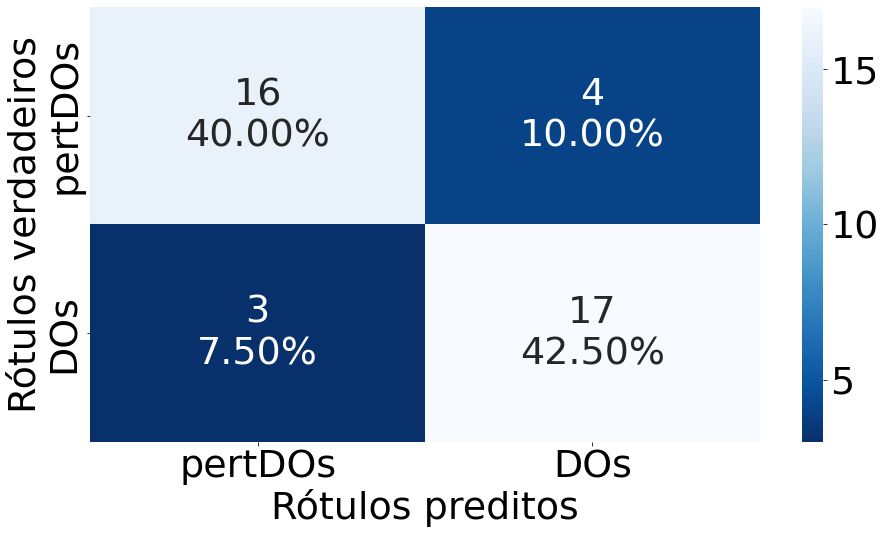

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

X_alvo =     df_dados_classificacao['classe'].tolist()
y_predicao = df_dados_classificacao['predicao'].tolist()

print(classification_report(X_alvo, y_predicao))

# Insere os dados no gráfico
cf_matrix = confusion_matrix(X_alvo, y_predicao)
quantidade_grupos = ["{0:0.0f}".format(valor) for valor in cf_matrix.flatten()]
percentual_grupos = ["{0:.2%}".format(valor) for valor in cf_matrix.flatten()/np.sum(cf_matrix)]
rotulos = [f"{v1}\n{v2}" for v1, v2 in zip(quantidade_grupos,percentual_grupos)]
rotulos = np.asarray(rotulos).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=rotulos, fmt='', cmap='Blues_r')

# Texto do eixo x
ax.set_xlabel('Rótulos preditos')
# Texto do eixo y
ax.set_ylabel('Rótulos verdadeiros')
# Rótulos adicionais
ax.xaxis.set_ticklabels(['pertDOs','DOs'])
ax.yaxis.set_ticklabels(['pertDOs','DOs'])

# Mostra o gráfico
plt.show()

### Listas em pares

#### Listas de pares de documentos originais e perturbados classificados corretamente

In [53]:
def listaClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []  
  lista_retorno_DO = []
  lista_retorno_pertDO = []
  for i, linha in df_dados_classificacao.iterrows():
    #if i < 20:    
    # 1 - Documento Original
    if linha['classe'] == 1 and linha['predicao'] == 1:
        lista_retorno_DO.append(linha['id'])
        lista_retorno.append(linha['id'])
    # 0 - Documento perturbado 
    if linha['classe'] == 0 and linha['predicao'] == 0:
        lista_retorno_pertDO.append(linha['id'])
        lista_retorno.append(linha['id'])
  
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  df_lista_retorno_DO = pd.DataFrame(lista_retorno_DO, columns = ["id"])
  df_lista_retorno_pertDO = pd.DataFrame(lista_retorno_pertDO, columns = ["id"])
  
  return df_lista_retorno, df_lista_retorno_DO, df_lista_retorno_pertDO

In [54]:
lista_retorno_classificado_corretamente, lista_retorno_DO_correto, lista_retorno_pertDO_correto = listaClassificadoCorretamente(df_dados_classificacao)
print('DO e pertDO classificados corretamente:', len(lista_retorno_classificado_corretamente))
print('DO classificados corretamente(VP)     :', len(lista_retorno_DO_correto))
print('pertDO classificados corretamente(FP) :', len(lista_retorno_pertDO_correto))

DO e pertDO classificados corretamente: 33
DO classificados corretamente(VP)     : 17
pertDO classificados corretamente(FP) : 16


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [55]:
def listaClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []  
  lista_retorno_DO = []
  lista_retorno_pertDO = []
  for i, linha in df_dados_classificacao.iterrows():
    # 1 - Documento Original
    if linha['classe'] == 1 and linha['predicao'] == 0:
        lista_retorno_DO.append(linha['id'])
        lista_retorno.append(linha['id'])        
    # 0 - Documento Perturbado
    if linha['classe'] == 0 and linha['predicao'] == 1:
        lista_retorno_pertDO.append(linha['id'])
        lista_retorno.append(linha['id'])
  
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])     
  df_lista_retorno_DO = pd.DataFrame(lista_retorno_DO, columns = ["id"])
  df_lista_retorno_pertDO = pd.DataFrame(lista_retorno_pertDO, columns = ["id"])

  return df_lista_retorno, df_lista_retorno_DO, df_lista_retorno_pertDO

In [56]:
lista_retorno_classificado_incorretamente, lista_retorno_DO_incorreto, lista_retorno_pertDO_incorreto = listaClassificadoIncorretamente(df_dados_classificacao)
print('DO e pertDO classificados incorretamente:', len(lista_retorno_classificado_incorretamente))
print('DO classificados incorretamente(VN)     :', len(lista_retorno_DO_incorreto))
print('pertDO classificados incorretamente(FN) :', len(lista_retorno_pertDO_incorreto))

DO e pertDO classificados incorretamente: 7
DO classificados incorretamente(VN)     : 3
pertDO classificados incorretamente(FN) : 4


#### Acurácia das listas

In [57]:
total = len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente)
print("Total de documentos                 :", total)
print("  Total de documentos originais     :", (len(lista_retorno_DO_correto)+len(lista_retorno_DO_incorreto)))
print("  Total de documentos perturbados   :", (len(lista_retorno_pertDO_correto)+len(lista_retorno_pertDO_incorreto)))
print("Total de acertos                    :", len(lista_retorno_classificado_corretamente))
print("Total de erros                      :", len(lista_retorno_classificado_incorretamente))
print()
print("Acurácia                                        : {0:.2%}".format(len(lista_retorno_classificado_corretamente)/total))
print("  DO coerentes       = Verdadeiros positivos(VP): {0:.2%}".format(len(lista_retorno_DO_correto)/total))
print("  pertDO incoerentes = Falsos positivos(FP)     : {0:.2%}".format(len(lista_retorno_pertDO_correto)/total))
print("  DO incoerentes     = Verdadeiro negativos(VN) : {0:.2%}".format(len(lista_retorno_DO_incorreto)/total))
print("  pertDO coerentes   = Falsos negativos(FN)     : {0:.2%}".format(len(lista_retorno_pertDO_incorreto)/total))

Total de documentos                 : 40
  Total de documentos originais     : 20
  Total de documentos perturbados   : 20
Total de acertos                    : 33
Total de erros                      : 7

Acurácia                                        : 82.50%
  DO coerentes       = Verdadeiros positivos(VP): 42.50%
  pertDO incoerentes = Falsos positivos(FP)     : 40.00%
  DO incoerentes     = Verdadeiro negativos(VN) : 7.50%
  pertDO coerentes   = Falsos negativos(FN)     : 10.00%


#### Listas documentos originais e perturbados e suas classificações sem repetições

Remove a duplicidade dos documentos originais classificados corretamente(VP)

In [58]:
print("Com repetição:",len(lista_retorno_DO_correto))
lista_retorno_DO_classificado_corretamente_sem_repeticao = lista_retorno_DO_correto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_DO_classificado_corretamente_sem_repeticao))

Com repetição: 17
Sem repetição: 17


Remove a duplicidade dos documentos originais classificados incorretamente(VN)

In [59]:
print("Com repetição:",len(lista_retorno_DO_incorreto))
lista_retorno_DO_classificado_incorretamente_sem_repeticao = lista_retorno_DO_incorreto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_DO_classificado_incorretamente_sem_repeticao))

Com repetição: 3
Sem repetição: 3


Remove a duplicidade dos documentos perturbados classificados corretamente(FP)

In [60]:
print("Com repetição:",len(lista_retorno_pertDO_correto))
lista_retorno_pertDO_classificado_corretamente_sem_repeticao = lista_retorno_pertDO_correto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_pertDO_classificado_corretamente_sem_repeticao))

Com repetição: 16
Sem repetição: 16


Remove a duplicidade dos documentos perturbados classificados incorretamente(FN)

In [61]:
print("Com repetição:",len(lista_retorno_pertDO_incorreto))
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao = lista_retorno_pertDO_incorreto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_pertDO_classificado_incorretamente_sem_repeticao))

Com repetição: 4
Sem repetição: 4


Remove as duplicidades dos documentos classificados corretamente.

In [62]:
print("Com repetição:",len(lista_retorno_classificado_corretamente))
lista_retorno_classificado_corretamente_sem_repeticao = lista_retorno_classificado_corretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_classificado_corretamente_sem_repeticao))

Com repetição: 33
Sem repetição: 33


Remove as duplicidades dos documentos perturbados classificados incorretamente.

In [63]:
print("Com repetição:",len(lista_retorno_classificado_incorretamente))
lista_retorno_classificado_incorretamente_sem_repeticao = lista_retorno_classificado_incorretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_classificado_incorretamente_sem_repeticao))

Com repetição: 7
Sem repetição: 7


### Listas

#### Lista de documentos originais(1) classificados corretamente(1)

In [64]:
def listaOriginalClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []  
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 1:
        lista_retorno.append(linha['id'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])        
  return df_lista_retorno

In [65]:
lista_documento_original_classificado_corretamente = listaOriginalClassificadoCorretamente(df_dados_classificacao)
print('lista_documento_original_classificado_corretamente:', len(lista_documento_original_classificado_corretamente))

lista_documento_original_classificado_corretamente: 17


In [66]:
print("Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1):", len(lista_documento_original_classificado_corretamente))
for i, documento in lista_documento_original_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1): 17
   0 - Como empilhar e desempilhar elementos em uma pilha? 1
   1 - O que é uma fila e como desenfileirar um elemento nela? 1
   2 - Como empilhar elementos em uma pilha? 1
   3 - O que é uma pilha e como empilhar e desempilhar seus elementos? 1
   4 - Como empilhar elementos em uma estrutura de dados pilha? 1
   5 - Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila? 1
   6 - Como desenfileirar elementos em uma fila? 1
   7 - Como desempilhar elementos em uma estrutura de dados pilha? 1
   8 - Como enfileirar elementos em uma fila? 1
   9 - O que é uma pilha e como empilhar um elemento nela? 1
   10 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   11 - O que é uma fila e como enfileirar seu elemento? 1
   12 - O que é uma fila e como enfileirar e desenfileirar seus elementos? 1
   13 - O que é uma pilha e como empilhar seu elemento?

#### Lista de documento originais(1) classificados incorretamente(0)

In [67]:
def listaOriginalClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []  
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 0:
        lista_retorno.append(linha['id'])
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [68]:
lista_documento_original_classificado_incorretamente = listaOriginalClassificadoIncorretamente(df_dados_classificacao)

print("Lista de documentos originais classificados incorretamente:",len(lista_documento_original_classificado_incorretamente))

Lista de documentos originais classificados incorretamente: 3


In [69]:
print("Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0):", len(lista_documento_original_classificado_incorretamente))
for i, documento in lista_documento_original_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0): 3
   0 - Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha? 1
   1 - Como desempilhar elementos em uma pilha? 1
   2 - Em uma pilha a operação de empilhar ocorre em qual extremidade? 1


#### Lista Documentos Perturbados(0) Classificados corretamente(0)

In [70]:
def listaPerturbadoClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []  
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 0:
        lista_retorno.append(linha['id'])
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [71]:
lista_documento_perturbado_classificado_corretamente = listaPerturbadoClassificadoCorretamente(df_dados_classificacao)
print('lista_documento_perturbado_classificado_corretamente:', len(lista_documento_perturbado_classificado_corretamente))

lista_documento_perturbado_classificado_corretamente: 16


In [72]:
print("Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0):", len(lista_documento_perturbado_classificado_corretamente))
for i, documento in lista_documento_perturbado_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0): 16
   0 - Como empilhar e desempilhar elementos em uma fila? 0
   1 - Como são implementadas as operações de empilhar e desempilhar elementos em uma fila? 0
   2 - O que é uma pilha e como desenfileirar um elemento nela? 0
   3 - Como empilhar elementos em uma fila? 0
   4 - O que é uma fila e como empilhar e desempilhar seus elementos? 0
   5 - Como empilhar elementos em uma estrutura de dados fila? 0
   6 - Como são implementadas as operações de enfileirar e desenfileirar elementos em uma pilha? 0
   7 - Como desempilhar elementos em uma estrutura de dados fila? 0
   8 - Como enfileirar elementos em uma pilha? 0
   9 - O que é uma fila e como empilhar um elemento nela? 0
   10 - Em uma pilha a operação de enfileirar ocorre em qual extremidade? 0
   11 - Em uma fila a operação de empilhar ocorre em qual extremidade? 0
   12 - O que é uma fila e como empilhar seu elemento? 0
   13 - O que é 

#### Lista Documentos Perturbados(0) Classificados incorretamente(1)

In [73]:
def listaPerturbadoClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []  
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 1:
        lista_retorno.append(linha['id'])
        
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [74]:
lista_documento_perturbado_classificado_incorretamente = listaPerturbadoClassificadoIncorretamente(df_dados_classificacao)
print('lista_documento_perturbado_classificado_incorretamente:', len(lista_documento_perturbado_classificado_incorretamente))

lista_documento_perturbado_classificado_incorretamente: 4


In [75]:
print("Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1):", len(lista_documento_perturbado_classificado_incorretamente))
for i, documento in lista_documento_perturbado_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1): 4
   0 - Como desempilhar elementos em uma fila? 0
   1 - Como desenfileirar elementos em uma pilha? 0
   2 - O que é uma pilha e como enfileirar seu elemento? 0
   3 - O que é uma pilha e como enfileirar e desenfileirar seus elementos? 0


# 3 Resultado do Cálculo das Medidas de (In)coerência

In [76]:
# Nome base das saidas do projeto
NOME_BASE_SAIDA = "MedidaCoerenciaCohebertManual_v1"

# Definição dos parâmetros a serem avaliados

## 3.1 Carrega os dados das medidas 

### 3.1.1 Função que encontra a melhor mensuração

In [77]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  EQUACAO_MEDIDA_NUM = [0, 1, 2]
  EQUACAO_MEDIDA = ["_adj","_com","_ctx"]

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  

  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_EQUACAO_MEDIDA = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []
  
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:
                for equacao in EQUACAO_MEDIDA:                      
                    for estrategia in ESTRATEGIA_MEDIDA:  
                      for filtro_palavra in FILTRO_PALAVRAS:  
                        # Acumuladores.                        
                        for i in range(len(arquivos)):                                    
                          if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                              and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                              and (modelo_bert in arquivos[i]) 
                              and (tamanho in arquivos[i]) 
                              and (modelo in arquivos[i])
                              and (equacao in arquivos[i])  
                              and (estrategia in arquivos[i]) 
                              and (filtro_palavra in arquivos[i])):
                                
                            NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                            # Verifica se o arquivo existe.
                            if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                              # Carrega os dados do arquivo  
                              dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                          
                              # Mostra os dados do teste da medida.
                              for index, linha in dados.iterrows():        
                                  # Cálculo das estatísticas
                                  ccos = (linha['ccos'])
                                  cman = (linha['cman'])
                                  ceuc = (linha['ceuc'])
                                  
                                  MELHOR_MEDIDA = -1
                                  MELHOR_MEDIDA_STR = ""
                                  if ccos >= cman and ccos >= ceuc:
                                      MELHOR_MEDIDA_STR = 'ccos'
                                      MELHOR_MEDIDA = ccos
                                  else:
                                      if ceuc >= ccos and ceuc >= cman:
                                          MELHOR_MEDIDA_STR = 'ceuc'
                                          MELHOR_MEDIDA = ceuc
                                      else:
                                          if cman >= ccos and cman >= ceuc:
                                            MELHOR_MEDIDA_STR = 'cman'
                                            MELHOR_MEDIDA = cman
                                  
                                  if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                    MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                    MELHOR_TOP_K_PREDICAO = top_k_predicao
                                    MELHOR_EQUACAO_MEDIDA = equacao
                                    MELHOR_ESTRATEGIA_MEDIDA = estrategia
                                    MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                    MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                    MELHOR_TEMPO = linha['tempo']
                                    MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                    MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                    MELHOR_MODELO_BERT = modelo_bert
                                    MELHOR_TAMANHO_BERT = tamanho
                                    MELHOR_MODELO = modelo

                                  lista_resultados.append([MELHOR_MODELO_BERT,
                                                          MELHOR_TAMANHO_BERT,
                                                          MELHOR_MODELO,
                                                          documentos_perturbados,
                                                          top_k_predicao, 
                                                          equacao,
                                                          estrategia, 
                                                          filtro_palavra, 
                                                          ccos, 
                                                          ceuc, 
                                                          cman,
                                                          MELHOR_MEDIDA_STR,
                                                          MELHOR_MEDIDA,                                                        
                                                          linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[10], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [78]:
# Parametros para o Cohebert Manual
DOCUMENTOS_PERTURBADOS = [1]
TOP_K_PREDICAO = [1]

# Recupera os melhores parâmetros
MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultados = getResultadosMensuracao(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO)

In [79]:
print("Parâmetros do melhor resultado do mensurador")
print("\n  Modelo BERT           :", MELHOR_MODELO_BERT, 
      "\n  Tamanho BERT          :", MELHOR_TAMANHO_BERT, 
      "\n  Modelo                :", MELHOR_MODELO,     
      "\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO, 
      "\n  Equação               :", MELHOR_EQUACAO_MEDIDA,
      "\n  Estratégia            :", MELHOR_ESTRATEGIA_MEDIDA, 
      "\n  Filtro                :", MELHOR_FILTRO_PALAVRAS, 
      "\n  Resultado             :", MELHOR_RESULTADO, 
      "\n  Medida                :", MELHOR_MEDIDA_GERAL_STR,       
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista dos resultados ranqueados")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros do melhor resultado do mensurador

  Modelo BERT           : _BERTimbau 
  Tamanho BERT          : _large 
  Modelo                : _pretreinado 
  Documentos Perturbados: 1 
  Top k predição        : 1 
  Equação               : _com 
  Estratégia            : _mean 
  Filtro                : _ssw 
  Resultado             : 0.7 
  Medida                : ccos 
  Tempo execução        : 0:00:07

Lista dos resultados ranqueados
1 = ['_BERTimbau', '_large', '_pretreinado', 1, 1, '_com', '_mean', '_ssw', 0.7, 0.65, 0.65, 'ccos', 0.7, '0:00:07']
2 = ['_BERTimbau', '_large', '_pretreinado', 1, 1, '_com', '_mean', '_svs', 0.7, 0.55, 0.7, 'ccos', 0.7, '0:00:07']
3 = ['_BERTimbau', '_large', '_pretreinado', 1, 1, '_adj', '_mean', '_ssw', 0.6, 0.6, 0.6, 'ccos', 0.6, '0:00:09']
4 = ['_BERTimbau', '_large', '_pretreinado', 1, 1, '_adj', '_mean', '_svs', 0.6, 0.55, 0.6, 'ccos', 0.6, '0:00:07']
5 = ['_BERTimbau', '_large', '_pretreinado', 1, 1, '_adj', '_max', '_ssw', 0.6, 0.6, 0.5, 'cc

### Escolhendo um resultado diferente do melhor

In [80]:
#MELHOR_MODELO_BERT = "_BERTimbau"
#MELHOR_TAMANHO_BERT = "_large"
#MELHOR_MODELO = "_pretreinado"
#MELHOR_DOCUMENTOS_PERTURBADOS = 1
#MELHOR_TOP_K_PREDICAO = 1
#MELHOR_EQUACAO_MEDIDA = "_adj"
#MELHOR_ESTRATEGIA_MEDIDA = "_mean"
#MELHOR_FILTRO_PALAVRAS = "_tap"
#lista_resultados= []

### 3.1.1 Função que carrega os parâmetros do resultado da melhor mensuração

In [81]:
def carregaMedidasCompactada(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO

  # Diretório do drive do arquivo
  DIRETORIO_MEDICAO_DRIVE = DIRETORIO_DRIVE + "validacao_medicao_palavra/Medicao/"

  # Diretório local para salvar o arquivo
  DIRETORIO_MEDICAO_LOCAL = DIRETORIO_LOCAL + "Medicao/"

  # Verifica se o diretório existe
  if not os.path.exists(DIRETORIO_MEDICAO_LOCAL):  
    # Cria o diretório
    os.makedirs(DIRETORIO_MEDICAO_LOCAL)
    logging.info("Diretório criado: {}.".format(DIRETORIO_MEDICAO_LOCAL))
  else:
    logging.info("Diretório já existe: {}.".format(DIRETORIO_MEDICAO_LOCAL))

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO_DRIVE):        

    # Caminho completo do arquivo compactado no drive
    NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO = DIRETORIO_MEDICAO_DRIVE + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO:", NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO)

    # Caminho completo do arquivo compactado no local
    NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO:", NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO)

    # Caminho completo do arquivo no local
    NOME_ARQUIVO_MEDICAO_LOCAL = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".csv"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL:", NOME_ARQUIVO_MEDICAO_LOCAL)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO):
      
      # Copia arquivo da medição compactado do google drive para o drive local
      !cp "$NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO" "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO"  
                        
      # Descompacta arquivo da medição compactado no drive local
      !unzip -o -j -q "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO" -d "$DIRETORIO_MEDICAO_LOCAL"

      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_LOCAL, sep=';')

      #print('Registros: ', len(dados_medida))
      print('Arquivo encontrado e carregado')        

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

In [82]:
def carregaMedidas1(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO + ".csv"

  # Diretório para salvar o arquivo.
  DIRETORIO_MEDICAO = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Medicao/"
  # print("DIRETORIO_MEDICAO:", DIRETORIO_MEDICAO)

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO):    

    # Caminho completo do arquivo
    NOME_ARQUIVO_MEDICAO_COMPLETO = DIRETORIO_MEDICAO + NOME_ARQUIVO_MEDICAO
    # print("NOME_ARQUIVO_MEDICAO_COMPLETO:", NOME_ARQUIVO_MEDICAO_COMPLETO)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_COMPLETO):
      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_COMPLETO, sep=';')

      print('Registros: ', len(dados_medida))

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

## 3.2 Carregamento dos arquivos de dados originais

### 3.2.1 Especifica os nomes dos arquivos de dados



In [83]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

### 3.2.2 Cria o diretório local para receber os dados

In [84]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-08-05 13:50:45,270 : INFO : Diretório já existe: /content/COHEBERT_MANUAL


### 3.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [85]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

2022-08-05 13:50:45,602 : INFO : Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [86]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

2022-08-05 13:50:45,966 : INFO : Terminei a descompactação!


### 3.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [87]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
dflista_documentos_agrupados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
dflista_documentos_agrupados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(dflista_documentos_agrupados)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(dflista_documentos_agrupados_pos)))

2022-08-05 13:50:46,031 : INFO : TERMINADO ORIGINAIS: 40.
2022-08-05 13:50:46,049 : INFO : TERMINADO ORIGINAIS POS: 40.


In [88]:
dflista_documentos_agrupados.sample(5)

,id,sentencas,documento,classe
27,28,['O que é uma fila e como empilhar um elemento...,O que é uma fila e como empilhar um elemento n...,0
2,3,['Como desenfileirar elementos em uma fila?'],Como desenfileirar elementos em uma fila?,1
23,24,['O que é uma fila e como desempilhar um eleme...,O que é uma fila e como desempilhar um element...,0
24,25,['O que é uma fila e como enfileirar um elemen...,O que é uma fila e como enfileirar um elemento...,1
20,21,['O que é uma fila e como desenfileirar um ele...,O que é uma fila e como desenfileirar um eleme...,1


In [89]:
dflista_documentos_agrupados_pos.sample(5)

,id,pos_documento
28,29,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."
36,37,"[[['Em', 'uma', 'pilha', 'a', 'operação', 'de'..."
19,20,"[[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como..."
32,33,"[[['Como', 'são', 'implementadas', 'as', 'oper..."
0,1,"[[['Como', 'enfileirar', 'elementos', 'em', 'u..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [90]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
dflista_documentos_agrupados["sentencas"] = dflista_documentos_agrupados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

dflista_documentos_agrupados_pos["pos_documento"] = dflista_documentos_agrupados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(dflista_documentos_agrupados)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(dflista_documentos_agrupados_pos)))

2022-08-05 13:50:46,215 : INFO : TERMINADO CORREÇÃO ORIGINAIS: 40.
2022-08-05 13:50:46,221 : INFO : TERMINADO CORREÇÃO ORIGINAIS POS: 40.


### 3.2.5 Separa os originais e perturbados

In [91]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = dflista_documentos_agrupados[dflista_documentos_agrupados["classe"]==0]
lista_documentos_perturbados_pos = dflista_documentos_agrupados_pos.loc[dflista_documentos_agrupados['classe'] == 0]

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-08-05 13:50:46,261 : INFO : TERMINADO PERTURBADOS: 20.
2022-08-05 13:50:46,268 : INFO : TERMINADO PERTURBADOS POS: 20.


In [92]:
lista_documentos_perturbados.sample(5)

,id,sentencas,documento,classe
23,24,[O que é uma fila e como desempilhar um elemen...,O que é uma fila e como desempilhar um element...,0
35,36,[Como são implementadas as operações de enfile...,Como são implementadas as operações de enfilei...,0
13,14,[Como desempilhar elementos em uma fila?],Como desempilhar elementos em uma fila?,0
11,12,[Como empilhar e desempilhar elementos em uma ...,Como empilhar e desempilhar elementos em uma e...,0
27,28,[O que é uma fila e como empilhar um elemento ...,O que é uma fila e como empilhar um elemento n...,0


In [93]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = dflista_documentos_agrupados[dflista_documentos_agrupados["classe"]==1]
lista_documentos_originais_pos = dflista_documentos_agrupados_pos.loc[dflista_documentos_agrupados['classe'] == 1]

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-08-05 13:50:46,352 : INFO : TERMINADO ORIGINAIS: 20.
2022-08-05 13:50:46,360 : INFO : TERMINADO ORIGINAIS POS: 20.


## 3.3 Carregando o resultado da melhor mensuração

In [94]:
MODELO_BERT = [MELHOR_MODELO_BERT]
TAMANHO_BERT = [MELHOR_TAMANHO_BERT]
MODELO = [MELHOR_MODELO] 
DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
EQUACAO_MEDIDA = [MELHOR_EQUACAO_MEDIDA]
ESTRATEGIA_MEDIDA = [MELHOR_ESTRATEGIA_MEDIDA]
FILTRO_PALAVRAS = [MELHOR_FILTRO_PALAVRAS]  

dados_mensuracao = carregaMedidasCompactada(MELHOR_MODELO_BERT, 
                                 MELHOR_TAMANHO_BERT,
                                 MELHOR_MODELO,
                                 MELHOR_DOCUMENTOS_PERTURBADOS, 
                                 MELHOR_TOP_K_PREDICAO,
                                 MELHOR_EQUACAO_MEDIDA,
                                 MELHOR_ESTRATEGIA_MEDIDA,
                                 MELHOR_FILTRO_PALAVRAS)

2022-08-05 13:50:46,377 : INFO : Diretório criado: /content/COHEBERT_MANUAL/Medicao/.


Arquivo encontrado e carregado


In [95]:
dados_mensuracao.sample(5)

,data,arquivo,ccos,ceuc,cman
10,12/07/2022 00:24,11,2.558744,95.361747,4682.744433
33,12/07/2022 00:24,34,2.554879,98.260752,4714.975467
22,12/07/2022 00:24,23,1.825757,72.361542,3559.995900
37,12/07/2022 00:24,38,2.054819,94.047279,4438.579540
27,12/07/2022 00:24,28,1.847093,70.254582,3485.228250


### Separa os documentos e remove as repetições

In [96]:
def separaDocumentos(dadosMedida):
  
  # Separa os originais
  df_original_medida = dadosMedida.loc[dadosMedida['arquivo']%2 == 1]
  # Remove os duplicados
  #df_original_medida = df_original_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Originais: ', len(df_original_medida))

  # Separa os perturbados
  df_perturbado_medida = dadosMedida.loc[dadosMedida['arquivo']%2 == 0]
  # Remove os duplicados
  #df_perturbado_medida = df_perturbado_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Perturbados: ', len(df_perturbado_medida))

  return df_original_medida, df_perturbado_medida

In [97]:
#df_original_medidaBERTimbaub, df_perturbado_medidaBERTimbaub = separaDocumentos(dadosMedidaBERTimbaub)

df_original_medidaBERTimbaul, df_perturbado_medidaBERTimbaul = separaDocumentos(dados_mensuracao)

#df_original_medidaBERTm, df_perturbado_medidadadosMedidaBERm = separaDocumentos(dadosMedidaBERTm)

Registros Originais:  20
Registros Perturbados:  20


### Organiza os pares de documentos

In [98]:
def organizaParesDocumentos(df_original_medida, df_perturbado_medida):

  # Import das bibliotecas.
  import pandas as pd

  lista_pares_documentos_medidas = []
  # Refaz os pares de documentos
  for i, documento_original in df_original_medida.iterrows():

    for j in range(0,MELHOR_DOCUMENTOS_PERTURBADOS):

      # No cohebert manual as versões perturbadas estão intercaladas com os originais
      nome_arquivo_perturbado =  documento_original['arquivo'] + (j + 1)

      documento_perturbado = df_perturbado_medida.loc[df_perturbado_medida['arquivo'] == nome_arquivo_perturbado]

      lista_pares_documentos_medidas.append(
                                      [documento_original['data'], 
                                       documento_original['arquivo'],	
                                       documento_original['ccos'], 
                                       documento_original['ceuc'], 
                                       documento_original['cman'],
                                       
                                       documento_perturbado['data'].values[0], 
                                       documento_perturbado['arquivo'].values[0],	
                                       documento_perturbado['ccos'].values[0], 
                                       documento_perturbado['ceuc'].values[0], 
                                       documento_perturbado['cman'].values[0] ],)

  print('Registros antes:', len(lista_pares_documentos_medidas))

  df_lista_pares_documentos_medidas = pd.DataFrame(lista_pares_documentos_medidas, columns=('data_DO', 
                                                                                            'id_DO',
                                                                                            'ccos_DO', 
                                                                                            'ceuc_DO', 
                                                                                            'cman_DO', 
                                                                                            'data_pertDO', 
                                                                                            'id_pertDO', 
                                                                                            'ccos_pertDO', 
                                                                                            'ceuc_pertDO', 
                                                                                            'cman_pertDO')) 
  
  print('Registros depois:', len(df_lista_pares_documentos_medidas))

  return df_lista_pares_documentos_medidas

In [99]:
df_lista_pares_documentos_medidasBERT = organizaParesDocumentos(df_original_medidaBERTimbaul, df_perturbado_medidaBERTimbaul)

Registros antes: 20
Registros depois: 20


In [100]:
df_lista_pares_documentos_medidasBERT.sample(5)

,data_DO,id_DO,ccos_DO,ceuc_DO,cman_DO,data_pertDO,id_pertDO,ccos_pertDO,ceuc_pertDO,cman_pertDO
18,12/07/2022 00:24,37,2.065246,93.569833,4427.441400,12/07/2022 00:24,38,2.054819,94.047279,4438.579540
1,12/07/2022 00:24,3,1.447072,60.357866,2859.316433,12/07/2022 00:24,4,1.420112,59.841868,2882.400633
0,12/07/2022 00:24,1,1.487195,57.129279,2761.598767,12/07/2022 00:24,2,1.470723,56.540777,2752.977067
8,12/07/2022 00:24,17,1.525227,54.160163,2682.880433,12/07/2022 00:24,18,1.501908,55.139950,2733.591967
15,12/07/2022 00:24,31,1.809024,73.413561,3659.760225,12/07/2022 00:24,32,1.821568,73.770772,3631.038950


In [101]:
lista_documentos_originais.sample(5)

,id,sentencas,documento,classe
26,27,[O que é uma pilha e como empilhar um elemento...,O que é uma pilha e como empilhar um elemento ...,1
38,39,[Em uma fila a operação de enfileirar ocorre e...,Em uma fila a operação de enfileirar ocorre em...,1
22,23,[O que é uma pilha e como desempilhar um eleme...,O que é uma pilha e como desempilhar um elemen...,1
16,17,[O que é uma pilha e como empilhar seu elemento?],O que é uma pilha e como empilhar seu elemento?,1
0,1,[Como enfileirar elementos em uma fila?],Como enfileirar elementos em uma fila?,1


## 3.4 Estatísticas das Medidas

### Listas em pares

#### Listas de pares de documentos originais e perturbados medidos corretamente

In [102]:
# Lista os documentos medidos corretamente
def listaMedidaCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos_":
      if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno  

In [103]:
lista_retorno_medido_corretamente = listaMedidaCorretamente(df_lista_pares_documentos_medidasBERT,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamente))

lista_retorno_medido_corretamente: 12


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [104]:
# Lista os documentos medidos incorretamente
def listaMedidaIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == 'ccos':
      if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
       # Medida de distância (euc, man)
       if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno  

In [105]:
lista_retorno_medido_incorretamente = listaMedidaIncorretamente(df_lista_pares_documentos_medidasBERT,
                                                                MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamente))

lista_retorno_medido_incorretamente: 28


#### Acertos das listas

In [106]:
total = len(lista_retorno_medido_corretamente) + len(lista_retorno_medido_incorretamente)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamente))
print("Total de erros     :", len(lista_retorno_medido_incorretamente))
print("Percentual acerto  :", len(lista_retorno_medido_corretamente)/total)

Total de documentos: 40
Total de acertos   : 12
Total de erros     : 28
Percentual acerto  : 0.3


#### Listas documentos originais e perturbados e suas medições sem repetições

Remove as duplicidades dos dados originais.

In [107]:
print("Com repetição:",len(lista_retorno_medido_corretamente))
lista_retorno_medido_corretamente_sem_repeticao = lista_retorno_medido_corretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_corretamente_sem_repeticao))

Com repetição: 12
Sem repetição: 12


Remove as duplicidades dos dados perturbados.

In [108]:
print("Com repetição:",len(lista_retorno_medido_incorretamente))
lista_retorno_medido_incorretamente_sem_repeticao = lista_retorno_medido_incorretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_incorretamente_sem_repeticao))

Com repetição: 28
Sem repetição: 28


#### Listas documentos originais e perturbados medidos corretamente

In [109]:
print("Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)):", len(lista_retorno_medido_corretamente))
conta = 0
for i, linha in lista_retorno_medido_corretamente.iterrows():
  conta = conta + 1
  if i < 2000:    
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == linha["id"]]       
    if len(documento)!= 0:    
      print("   ", conta, documento['documento'].values[0], documento['classe'].values[0])

Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)): 12
    1 Como desempilhar elementos em uma pilha? 1
    2 Como desempilhar elementos em uma fila? 0
    3 O que é uma fila e como enfileirar seu elemento? 1
    4 O que é uma pilha e como enfileirar seu elemento? 0
    5 O que é uma fila e como desenfileirar um elemento nela? 1
    6 O que é uma pilha e como desenfileirar um elemento nela? 0
    7 O que é uma fila e como enfileirar um elemento nela? 1
    8 O que é uma pilha e como enfileirar um elemento nela? 0
    9 O que é uma fila e como enfileirar e desenfileirar seus elementos? 1
    10 O que é uma pilha e como enfileirar e desenfileirar seus elementos? 0
    11 Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha? 1
    12 Como são implementadas as operações de empilhar e desempilhar elementos em uma fila? 0


#### Listas documentos originais e perturbados medidos incorretamente

In [110]:
print("Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)):", len(lista_retorno_medido_incorretamente))
conta = 0
for i, linha in lista_retorno_medido_incorretamente.iterrows():
  conta = conta + 1
  if i < 2000:    
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == linha["id"]]       
    if len(documento)!= 0:    
      print("   ", conta, documento['documento'].values[0], documento['classe'].values[0])

Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)): 28
    1 Como enfileirar elementos em uma fila? 1
    2 Como enfileirar elementos em uma pilha? 0
    3 Como desenfileirar elementos em uma fila? 1
    4 Como desenfileirar elementos em uma pilha? 0
    5 Como empilhar elementos em uma pilha? 1
    6 Como empilhar elementos em uma fila? 0
    7 Como empilhar e desempilhar elementos em uma pilha? 1
    8 Como empilhar e desempilhar elementos em uma fila? 0
    9 Como empilhar elementos em uma estrutura de dados pilha? 1
    10 Como empilhar elementos em uma estrutura de dados fila? 0
    11 Como empilhar e desempilhar elementos em uma estrutura de dados pilha? 1
    12 Como empilhar e desempilhar elementos em uma estrutura de dados fila? 0
    13 Como desempilhar elementos em uma estrutura de dados pilha? 1
    14 Como desempilhar elementos em uma estrutura de dados fila? 0
    15 O que é uma pilha e como empilhar seu elemento? 1
    16 O que é uma f

### Listas

#### Lista de documentos originais(1) medidos corretamente(1)

In [111]:
def listaOriginalMedidoCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  dflista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return dflista_retorno  

In [112]:
lista_documento_original_medido_corretamente = listaOriginalMedidoCorretamente(df_lista_pares_documentos_medidasBERT, MELHOR_MEDIDA_GERAL_STR)
print('lista_documento_original_medido_corretamente:', len(lista_documento_original_medido_corretamente))

lista_documento_original_medido_corretamente: 6


In [113]:
print("Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)):", len(lista_documento_original_medido_corretamente))
for i, documento in lista_documento_original_medido_corretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)): 6
   0 - Como desempilhar elementos em uma pilha? 1
   1 - O que é uma fila e como enfileirar seu elemento? 1
   2 - O que é uma fila e como desenfileirar um elemento nela? 1
   3 - O que é uma fila e como enfileirar um elemento nela? 1
   4 - O que é uma fila e como enfileirar e desenfileirar seus elementos? 1
   5 - Como são implementadas as operações de empilhar e desempilhar elementos em uma pilha? 1


#### Lista de documento originais(1) medidos incorretamente(0)

In [114]:
def listaOriginalMedidoIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  dflista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return dflista_retorno  

In [115]:
lista_documento_original_medido_incorretamente = listaOriginalMedidoIncorretamente(df_lista_pares_documentos_medidasBERT, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos originais medidos incorretamente:",len(lista_documento_original_medido_incorretamente))

Lista de documentos originais medidos incorretamente: 14


In [116]:
print("Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)):", len(lista_documento_original_medido_incorretamente))
for i, documento in lista_documento_original_medido_incorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)): 14
   0 - Como enfileirar elementos em uma fila? 1
   1 - Como desenfileirar elementos em uma fila? 1
   2 - Como empilhar elementos em uma pilha? 1
   3 - Como empilhar e desempilhar elementos em uma pilha? 1
   4 - Como empilhar elementos em uma estrutura de dados pilha? 1
   5 - Como empilhar e desempilhar elementos em uma estrutura de dados pilha? 1
   6 - Como desempilhar elementos em uma estrutura de dados pilha? 1
   7 - O que é uma pilha e como empilhar seu elemento? 1
   8 - O que é uma pilha e como desempilhar um elemento nela? 1
   9 - O que é uma pilha e como empilhar um elemento nela? 1
   10 - O que é uma pilha e como empilhar e desempilhar seus elementos? 1
   11 - Como são implementadas as operações de enfileirar e desenfileirar elementos em uma fila? 1
   12 - Em uma pilha a operação de empilhar ocorre em qual extremidade? 1
   13 - Em uma fila a operação de enfileirar ocorre em q

#### Lista Documentos Perturbados(0) medidos corretamente(0)

In [117]:
def listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  dflista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return dflista_retorno    

In [118]:
lista_documento_perturbado_medido_corretamente  = listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_medidasBERT, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos corretamente:",len(lista_documento_perturbado_medido_corretamente ))

Lista de documentos perturbados medidos corretamente: 6


In [119]:
print("Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)):", len(lista_documento_perturbado_medido_corretamente ))
for i, documento in lista_documento_perturbado_medido_corretamente .iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)): 6
   0 - Como desempilhar elementos em uma fila? 0
   1 - O que é uma pilha e como enfileirar seu elemento? 0
   2 - O que é uma pilha e como desenfileirar um elemento nela? 0
   3 - O que é uma pilha e como enfileirar um elemento nela? 0
   4 - O que é uma pilha e como enfileirar e desenfileirar seus elementos? 0
   5 - Como são implementadas as operações de empilhar e desempilhar elementos em uma fila? 0


#### Lista Documentos Perturbados(0) medidos  incorretamente(1)

In [120]:
def listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  dflista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return dflista_retorno    

In [121]:
lista_documento_perturbado_medido_incorretamente = listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_medidasBERT, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos incorretamente:",len(lista_documento_perturbado_medido_incorretamente))

Lista de documentos perturbados medidos incorretamente: 14


In [122]:
print("Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)):", len(lista_documento_perturbado_medido_incorretamente))
for i, documento in lista_documento_perturbado_medido_incorretamente.iterrows():
    # Recupera o documento a ser exibido   
    documento = dflista_documentos_agrupados.loc[dflista_documentos_agrupados["id"] == documento["id"]]   
    
    print("  ",i, "-", documento['documento'].values[0], documento['classe'].values[0])

Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)): 14
   0 - Como enfileirar elementos em uma pilha? 0
   1 - Como desenfileirar elementos em uma pilha? 0
   2 - Como empilhar elementos em uma fila? 0
   3 - Como empilhar e desempilhar elementos em uma fila? 0
   4 - Como empilhar elementos em uma estrutura de dados fila? 0
   5 - Como empilhar e desempilhar elementos em uma estrutura de dados fila? 0
   6 - Como desempilhar elementos em uma estrutura de dados fila? 0
   7 - O que é uma fila e como empilhar seu elemento? 0
   8 - O que é uma fila e como desempilhar um elemento nela? 0
   9 - O que é uma fila e como empilhar um elemento nela? 0
   10 - O que é uma fila e como empilhar e desempilhar seus elementos? 0
   11 - Como são implementadas as operações de enfileirar e desenfileirar elementos em uma pilha? 0
   12 - Em uma pilha a operação de enfileirar ocorre em qual extremidade? 0
   13 - Em uma fila a operação de empilhar ocorre em qual ex

# 5 Compara os resultados

Listas das classificações
* lista_documento_original_classificado_corretamente
* lista_documento_original_classificado_incorretamente
* lista_documento_perturbado_classificado_corretamente
* lista_documento_perturbado_classificado_incorretamente


Lista das medições
* lista_documento_original_medido_corretamente 12
* lista_documento_original_medido_incorretamente 8
* lista_documento_perturbado_medido_corretamente 12
* lista_documento_perturbado_medido_incorretamente 8

In [123]:
total_classificacao = (len(lista_documento_original_classificado_corretamente) + 
                       len(lista_documento_original_classificado_incorretamente) + 
                       len(lista_documento_perturbado_classificado_corretamente) + 
                       len(lista_documento_perturbado_classificado_incorretamente))
print("total_classificacao:", total_classificacao)

print("DO classificados corretamente:", 
      len(lista_documento_original_classificado_corretamente), 
      " / {0:.2%} do total".format(len(lista_documento_original_classificado_corretamente)/total_classificacao))
print("DO classificados incorretamente:", 
      len(lista_documento_original_classificado_incorretamente), 
      " / {0:.2%} do total".format(len(lista_documento_original_classificado_incorretamente)/total_classificacao))
print("pertDO classificados corretamente:", 
      len(lista_documento_perturbado_classificado_corretamente), 
      " / {0:.2%} do total".format(len(lista_documento_perturbado_classificado_corretamente)/total_classificacao))
print("pertDO classificados incorretamente:", 
      len(lista_documento_perturbado_classificado_incorretamente), 
      " / {0:.2%} do total".format(len(lista_documento_perturbado_classificado_incorretamente)/total_classificacao))

total_medicao = (len(lista_documento_original_medido_corretamente) +
                 len(lista_documento_original_medido_incorretamente) + 
                 len(lista_documento_perturbado_medido_corretamente) + 
                 len(lista_documento_perturbado_medido_incorretamente))

print()
print("total_medicao:",total_medicao)

print("DO medidos corretamente:", 
      len(lista_documento_original_medido_corretamente), 
      " / {0:.2%} do total".format(len(lista_documento_original_medido_corretamente)/total_medicao))
print("DO medidos incorretamente:", 
      len(lista_documento_original_medido_incorretamente), 
      " / {0:.2%} do total".format(len(lista_documento_original_medido_incorretamente)/total_medicao))
print("pertDO medidos corretamente:", 
      len(lista_documento_perturbado_medido_corretamente), 
      " / {0:.2%} do total".format(len(lista_documento_perturbado_medido_corretamente)/total_medicao))
print("pertDO medidos incorretamente:", 
      len(lista_documento_perturbado_medido_incorretamente), 
      " / {0:.2%} do total".format(len(lista_documento_perturbado_medido_incorretamente)/total_medicao))

total_classificacao: 40
DO classificados corretamente: 17  / 42.50% do total
DO classificados incorretamente: 3  / 7.50% do total
pertDO classificados corretamente: 16  / 40.00% do total
pertDO classificados incorretamente: 4  / 10.00% do total

total_medicao: 40
DO medidos corretamente: 6  / 15.00% do total
DO medidos incorretamente: 14  / 35.00% do total
pertDO medidos corretamente: 6  / 15.00% do total
pertDO medidos incorretamente: 14  / 35.00% do total


## Documentos originais classificados e medidos corretamente

In [124]:
lista_intersecao = []
for i, documento1 in lista_documento_original_classificado_corretamente.iterrows():
  procura = documento1["id"]
  documento2 = lista_documento_original_medido_corretamente.loc[lista_documento_original_medido_corretamente["id"] == procura]
  if len(documento2) != 0:        
      lista_intersecao.append(documento1["id"])

In [125]:
if len(lista_intersecao) != 0:    
  percentual = len(lista_intersecao)/total_classificacao
  print ("Lista de documentos originais que foram classificados e medidos corretamente: ", len(lista_intersecao), " / {0:.2%} do total".format( percentual))
  for i, x in enumerate(lista_intersecao):
    if i < 100:
      print(x)
else:
  print("Não existe documentos originais que foram classificados e medidos corretamente ")

Lista de documentos originais que foram classificados e medidos corretamente:  4  / 10.00% do total
21
19
31
25


## Documentos originais classificados e medidos incorretamente

In [126]:
lista_intersecao = []
for i, documento1 in lista_documento_original_classificado_incorretamente.iterrows():
  procura = documento1["id"]
  documento2 = lista_documento_original_medido_incorretamente.loc[lista_documento_original_medido_incorretamente["id"] == procura]
  if len(documento2) != 0:        
      lista_intersecao.append(documento1["id"])

In [127]:
if len(lista_intersecao) != 0:    
  percentual = len(lista_intersecao)/total_classificacao
  print ("Lista de documentos originais que foram classificados e medidos incorretamente: ", len(lista_intersecao), " / {0:.2%} do total".format( percentual))
  for i, x in enumerate(lista_intersecao):
    if i < 100:
      print(x)
else:
  print("Não existe documentos originais que foram classificados e medidos incorretamente ")

Lista de documentos originais que foram classificados e medidos incorretamente:  1  / 2.50% do total
37


## Documentos perturbados classificados e medidos corretamente

In [128]:
lista_intersecao = []
for i, documento1 in lista_documento_perturbado_classificado_corretamente.iterrows():
  procura = documento1["id"]
  documento2 = lista_documento_perturbado_medido_corretamente.loc[lista_documento_perturbado_medido_corretamente["id"] == procura]
  if len(documento2) != 0:        
      lista_intersecao.append(documento1["id"])

In [129]:
if len(lista_intersecao) != 0:    
  percentual = len(lista_intersecao)/total_classificacao
  print ("Lista de documentos perturbados que foram classificados e medidos corretamente: ", len(lista_intersecao), " / {0:.2%} do total".format( percentual))
  for i, x in enumerate(lista_intersecao):
    if i < 100:
      print(x)
else:
  print("Não existe documentos perturbados que foram classificados e medidos corretamente ")

Lista de documentos perturbados que foram classificados e medidos corretamente:  3  / 7.50% do total
34
22
26


## Documentos perturbados classificados e medidos incorretamente

In [130]:
lista_intersecao = []
for i, documento1 in lista_documento_perturbado_classificado_incorretamente.iterrows():
  procura = documento1["id"]
  documento2 = lista_documento_perturbado_medido_incorretamente.loc[lista_documento_perturbado_medido_incorretamente["id"] == procura]
  if len(documento2) != 0:        
      lista_intersecao.append(documento1["id"])

In [131]:
if len(lista_intersecao) != 0:    
  percentual = len(lista_intersecao)/total_classificacao
  print ("Lista de documentos perturbados que foram classificados e medidos incorretamente: ", len(lista_intersecao), " / {0:.2%} do total".format( percentual))
  for i, x in enumerate(lista_intersecao):
    if i < 20:
      print(x)
else:
  print("Não existe documentos perturbados que foram classificados e medidos incorretamente ")

Lista de documentos perturbados que foram classificados e medidos incorretamente:  1  / 2.50% do total
4


# 6 Finalização

## 6.3 Tempo final de processamento



In [132]:
 # Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print('')
print('  Tempo processamento:  {:} (h:mm:ss)'.format(tempo_total_processamento))


  Tempo processamento:  0:02:27 (h:mm:ss)
